In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./combined.csv
./weirdos2.csv
./weirdos.csv
./greenwich_village_housing_data.csv
./wait.csv
./Project_2.ipynb
./combined2.csv
./.ipynb_checkpoints/combined2-checkpoint.csv
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./.ipynb_checkpoints/wait-checkpoint.csv
./.ipynb_checkpoints/test-checkpoint.csv
./.ipynb_checkpoints/for_rent_homes-checkpoint.csv
./.ipynb_checkpoints/web_scraper-checkpoint.ipynb
./.ipynb_checkpoints/weirdos-checkpoint.csv
./.ipynb_checkpoints/combined-checkpoint.csv
./.ipynb_checkpoints/greenwich_village_housing_data-checkpoint.csv
./.ipynb_checkpoints/weirdos2-checkpoint.csv
./csv_files/combined.csv
./csv_files/for_rent_homes.csv
./csv_files/sold_homes.csv
./csv_files/pending_homes.csv
./csv_files/for_sale_homes.csv
./csv_files/.ipynb_checkpoints/for_sale_homes-checkpoint.csv
./csv_files/.ipynb_checkpoints/for_rent_homes-checkpoint.csv
./csv_files/.ipynb_checkpoints/sold_homes-checkpoint.csv
./csv_files/.ipynb_checkpoints/pending_homes-checkpoint.csv


In [4]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from homeharvest import scrape_property
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Build a model (or a system of models) that accurately predicts housing prices for properties located within the Greenwich Village area in New York City. This system will take in a set of parameters (yet to be fully determined; could consist of the number of rooms, square feet, proximity to parks, etc.), and generate a realistic price for the parameters given. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [3]:
all_properties = [] 

locations = [
    '10003',
    '10011',
    '10014',
    '10012',
    '10009',
    '10007',
    '10013',
    '10002',
] # greenwich village zip codes 

listing_types = [
    'sold',
    'for_sale',
    'pending',
    'for_rent'
] # all listings

for loc in locations:
    for listing_type in listing_types:
        properties = scrape_property(
            location=loc,
            listing_type=listing_type,
            past_days=730
        )
        
        print(f'for zip code {loc} + listing type as {listing_type}, {len(properties)} results were found')
        
        all_properties.append(properties)
        # time.sleep(5)

all_properties = pd.concat(all_properties, ignore_index=True)
all_properties = all_properties.drop_duplicates(subset=['property_id'])
all_properties.to_csv('greenwich_village_housing_data.csv', index=False)

for zip code 10003 + listing type as sold, 540 results were found
for zip code 10003 + listing type as for_sale, 364 results were found
for zip code 10003 + listing type as pending, 74 results were found
for zip code 10003 + listing type as for_rent, 272 results were found
for zip code 10011 + listing type as sold, 760 results were found
for zip code 10011 + listing type as for_sale, 488 results were found
for zip code 10011 + listing type as pending, 69 results were found
for zip code 10011 + listing type as for_rent, 412 results were found
for zip code 10014 + listing type as sold, 376 results were found
for zip code 10014 + listing type as for_sale, 210 results were found
for zip code 10014 + listing type as pending, 29 results were found
for zip code 10014 + listing type as for_rent, 313 results were found
for zip code 10012 + listing type as sold, 168 results were found
for zip code 10012 + listing type as for_sale, 158 results were found
for zip code 10012 + listing type as pendi

/tmp/ipykernel_3549854/1715810810.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_properties = pd.concat(all_properties, ignore_index=True)


In [4]:
print(len(all_properties)) # result: 4088 properties
all_properties.head() # just checking

6354


,property_url,property_id,listing_id,permalink,mls,mls_id,status,mls_status,text,style,...,builder_id,builder_name,office_id,office_mls_set,office_name,office_email,office_phones,nearby_schools,primary_photo,alt_photos
0,https://www.realtor.com/realestateandhomes-det...,4592027572,<NA>,835-Broadway-E2_New-York_NY_10003_M45920-27572,<NA>,<NA>,SOLD,<NA>,<NA>,CONDO,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"New York City Geographic District # 2, SUCCESS...",<NA>,<NA>
1,https://www.realtor.com/realestateandhomes-det...,9452176423,2978063277,710-Broadway_New-York_NY_10003_M94521-76423,DENY,23341986,SOLD,Sold,NoHo Penthouse full floor loft with four bedro...,COOP,...,<NA>,<NA>,2277890,O-DENY-77,111 Fifth,lead.manager@elliman.com,"[{'number': '2126454040', 'type': 'Office', 'p...","New York City Geographic District # 2, SUCCESS...",https://ap.rdcpix.com/b80a1d20241e99603b441379...,https://ap.rdcpix.com/b80a1d20241e99603b441379...
2,https://www.realtor.com/realestateandhomes-det...,4217179547,<NA>,23-E-10th-St-Apt-5A_New-York_NY_10003_M42171-7...,<NA>,<NA>,SOLD,<NA>,<NA>,CONDO,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"New York City Geographic District # 2, SUCCESS...",https://ap.rdcpix.com/b94c26bbb74059688af8aaec...,https://ap.rdcpix.com/b94c26bbb74059688af8aaec...
3,https://www.realtor.com/realestateandhomes-det...,4292213040,<NA>,305-2nd-Ave-Apt-719_New-York_NY_10003_M42922-1...,<NA>,<NA>,SOLD,<NA>,<NA>,CONDO,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"New York City Geographic District # 2, SUCCESS...",https://ap.rdcpix.com/dd8c88f552a391f4ca1e0f73...,https://ap.rdcpix.com/dd8c88f552a391f4ca1e0f73...
4,https://www.realtor.com/realestateandhomes-det...,3535692885,<NA>,67-E-11th-St-Apt-718_New-York_NY_10003_M35356-...,<NA>,<NA>,SOLD,<NA>,<NA>,COOP,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"New York City Geographic District # 2, SUCCESS...",<NA>,<NA>


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [5]:
print(all_properties['zip_code'].value_counts())

zip_code
10011    1615
10003    1158
10014     876
10002     806
10013     750
10012     461
10009     390
10007     298
Name: count, dtype: int64


In [6]:
# drop contingent values
all_properties = all_properties[all_properties['status'] != 'CONTINGENT']
print(all_properties['status'].value_counts())

status
SOLD        2685
FOR_RENT    1891
FOR_SALE    1262
PENDING      508
Name: count, dtype: int64


In [7]:
print(all_properties['sqft'].isnull().sum()) 

2927


In [8]:
price_cols = [
    'list_price', 
    # 'list_price_min', 
    # 'list_price_max', 
    'sold_price', 
    'last_sold_price', 
    'assessed_value', 
    'estimated_value'
]

for col in price_cols:
    print(f'------DATA FOR COLUMN \'{col.upper()}\'------')
    
    null_counts = all_properties.groupby('status')[col].apply(lambda x: x.isnull().sum())
    for status in listing_types:
        total = len(all_properties[all_properties['status'] == status.upper()])
        if status.upper() in null_counts.index:
            print(f'number of null values ({status}): {null_counts[status.upper()]}/{total}')
        else: print(f'number of null values ({status}): 0')
            

    print(f'\nmin: {all_properties[col].min():,.2f}')
    print(f'max: {all_properties[col].max():,.2f}')
    print(f'q1: {all_properties[col].quantile(0.25):,.2f}')
    print(f'q3: {all_properties[col].quantile(0.75):,.2f}')
    print(f'mean: {all_properties[col].mean():,.2f}')
    print(f'median: {all_properties[col].median():,.2f}\n')

------DATA FOR COLUMN 'LIST_PRICE'------
number of null values (sold): 1809/2685
number of null values (for_sale): 3/1262
number of null values (pending): 0/508
number of null values (for_rent): 237/1891

min: 1,535.00
max: 399,500,000.00
q1: 6,690.00
q3: 2,395,000.00
mean: 2,200,398.60
median: 725,000.00

------DATA FOR COLUMN 'SOLD_PRICE'------
number of null values (sold): 0/2685
number of null values (for_sale): 633/1262
number of null values (pending): 270/508
number of null values (for_rent): 1679/1891

min: 5,000.00
max: 138,930,068.00
q1: 850,000.00
q3: 3,370,556.25
mean: 3,028,488.94
median: 1,702,500.00

------DATA FOR COLUMN 'LAST_SOLD_PRICE'------
number of null values (sold): 0/2685
number of null values (for_sale): 633/1262
number of null values (pending): 270/508
number of null values (for_rent): 1679/1891

min: 5,000.00
max: 138,930,068.00
q1: 850,000.00
q3: 3,370,556.25
mean: 3,028,488.94
median: 1,702,500.00

------DATA FOR COLUMN 'ASSESSED_VALUE'------
number of null

## conclusion:
- use LIST_PRICE for all FOR_SALE and PENDING properties
- use SOLD_PRICE for all SOLD properties
- use LIST_PRICE for all FOR_RENT properties
    - for FOR_RENT properties missing the LIST_PRICE column:
        - average out their LIST_PRICE_MIN and LIST_PRICE_MAX
    - everything else just drop!

In [9]:
# analyze suspiciously low "sold prices" and other rows that r missing data

min_price_range = 200000

weirdos = all_properties[all_properties['sold_price'] < min_price_range]
weirdos.to_csv('weirdos.csv', index=False)
print(weirdos.head())

weirdos2 = all_properties[(all_properties['status'] == 'FOR_RENT') & (all_properties['list_price'].isnull())]
weirdos2.to_csv('weirdos2.csv', index=False)
print(weirdos2.head())

bed_null_count = len(all_properties[all_properties['beds'].isnull()])
bath_null_count = len(all_properties[all_properties['full_baths'].isnull()])
print(f'number of rows that have null values for beds column: {bed_null_count}')
print(f'number of rows that have null values for baths column: {bath_null_count}')

garage_nonnull_count = len(all_properties) - len(all_properties[all_properties['parking_garage'].isnull()])
print(f'number of rows that have a value for parking garage: {garage_nonnull_count}')

school_nonnull_count = len(all_properties) - len(all_properties[all_properties['nearby_schools'].isnull()])
print(f'number of rows that have a value for nearby schools: {school_nonnull_count}')

                                           property_url property_id  \
208   https://www.realtor.com/realestateandhomes-det...  9104456986   
322   https://www.realtor.com/realestateandhomes-det...  9387879318   
524   https://www.realtor.com/realestateandhomes-det...  9412159427   
584   https://www.realtor.com/realestateandhomes-det...  3168024681   
1255  https://www.realtor.com/realestateandhomes-det...  3823323900   

      listing_id                                          permalink   mls  \
208         <NA>  215-E-19th-St-Apt-11G_New-York_NY_10003_M91044...  <NA>   
322         <NA>   70-E-10th-St-Hlwy_New-York_NY_10003_M93878-79318  <NA>   
524   2981857475  300-Mercer-St-Apt-10I_New-York_NY_10003_M94121...  DENY   
584   2984902424       135-E-19th-St_New-York_NY_10003_M31680-24681  DENY   
1255        <NA>  351-W-24th-St-Apt-2H_New-York_NY_10011_M38233-...  <NA>   

        mls_id    status mls_status  \
208       <NA>      SOLD       <NA>   
322       <NA>      SOLD       <

In [10]:
print('all column names: ')
print(all_properties.columns)

all column names: 
Index(['property_url', 'property_id', 'listing_id', 'permalink', 'mls',
       'mls_id', 'status', 'mls_status', 'text', 'style', 'formatted_address',
       'full_street_line', 'street', 'unit', 'city', 'state', 'zip_code',
       'beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls',
       'list_price', 'list_price_min', 'list_price_max', 'list_date',
       'pending_date', 'sold_price', 'last_sold_date', 'last_sold_price',
       'assessed_value', 'estimated_value', 'tax', 'tax_history',
       'new_construction', 'lot_sqft', 'price_per_sqft', 'latitude',
       'longitude', 'neighborhoods', 'county', 'fips_code', 'stories',
       'hoa_fee', 'parking_garage', 'agent_id', 'agent_name', 'agent_email',
       'agent_phones', 'agent_mls_set', 'agent_nrds_id', 'broker_id',
       'broker_name', 'builder_id', 'builder_name', 'office_id',
       'office_mls_set', 'office_name', 'office_email', 'office_phones',
       'nearby_schools', 'primary_photo',

In [11]:
# further data analysis 

sold_df = all_properties[all_properties['status'] == 'SOLD']
for_rent_df = all_properties[all_properties['status'] == 'FOR_RENT']
for_sale_df = all_properties[all_properties['status'] == 'FOR_SALE']
pending_df = all_properties[all_properties['status'] == 'PENDING'] 

temp_dfs = [sold_df, for_rent_df, for_sale_df, pending_df] 

for df in temp_dfs: 
    print(f"\n----DATA ANALYSIS ON {df['status'].iloc[0]} DF----\n")
    print(f"PRICE RANGE:\n-----")
    print(f"min: {df['sold_price'].min():,.1f}\t\tmax: {df['sold_price'].max():,.1f}")
    print(f"median: {df['sold_price'].median():,.1f}\tmean: {df['sold_price'].mean():,.1f}")
    print(f"\nBED/BATH COLUMNS:\n-----")
    print(f"null bed rows: {len(df[df['beds'].isnull()])}/{len(df)}", end='\t\t')
    print(f"null bath rows: {len(df[df['full_baths'].isnull()])}/{len(df)}", end='\t')
    print(f"\nbeds count median: {df['beds'].median():.1f}\t\tbaths count median: {df['full_baths'].median():.1f}")
    print(f"beds count mean: {df['beds'].mean():.1f}\t\tbaths count mean: {df['full_baths'].mean():.1f}")


----DATA ANALYSIS ON SOLD DF----

PRICE RANGE:
-----
min: 5,350.0		max: 132,000,000.0
median: 1,950,000.0	mean: 3,304,091.5

BED/BATH COLUMNS:
-----
null bed rows: 1804/2685		null bath rows: 2539/2685	
beds count median: 2.0		baths count median: 1.0
beds count mean: 1.8		baths count mean: 1.2

----DATA ANALYSIS ON FOR_RENT DF----

PRICE RANGE:
-----
min: 139,250.0		max: 138,930,068.0
median: 1,262,500.0	mean: 2,671,029.8

BED/BATH COLUMNS:
-----
null bed rows: 236/1891		null bath rows: 243/1891	
beds count median: 1.0		baths count median: 1.0
beds count mean: 1.5		baths count mean: 1.3

----DATA ANALYSIS ON FOR_SALE DF----

PRICE RANGE:
-----
min: 18,000.0		max: 45,000,000.0
median: 1,360,000.0	mean: 2,444,118.3

BED/BATH COLUMNS:
-----
null bed rows: 0/1262		null bath rows: 14/1262	
beds count median: 2.0		baths count median: 2.0
beds count mean: 2.1		baths count mean: 2.0

----DATA ANALYSIS ON PENDING DF----

PRICE RANGE:
-----
min: 5,000.0		max: 16,000,000.0
median: 995,000.0	mean:

In [12]:
print(all_properties['nearby_schools'].value_counts())

nearby_schools
New York City Geographic District # 2                                                                                                                                     2987
New York City Geographic District # 2, New York City Special Schools - District 75                                                                                         745
New York City Geographic District # 2, SUCCESS ACADEMY CHARTER SCHOOL-UNION SQUARE                                                                                         577
New York City Special Schools - District 75, New York City Geographic District # 1                                                                                         388
New York City Geographic District # 1                                                                                                                                      309
New York City Geographic District # 2, SUCCESS ACADEMY CHARTER SCHOOL-UNION SQUARE, New York City Special Scho

# 4.Prepare the Data


Apply any data transformations and explain what and why

In [13]:
# step 1: keep only relevant columns
keep_colnames = ['status',
                 'style',
                 'zip_code',
                 'beds',
                 'full_baths',
                 'sqft',
                 'year_built',
                 'list_price',
                 'list_price_min',
                 'list_price_max',
                 'sold_price',
                 'new_construction',
                 'latitude',
                 'longitude',
                 'stories',
                ]

new_df = all_properties[keep_colnames].copy()

# separate into sold, for_rent, pending, and for_sale

sold_homes = new_df[new_df['status'] == 'SOLD'].copy()
for_rent_homes = new_df[new_df['status'] == 'FOR_RENT'].copy()
pending_homes = new_df[new_df['status'] == 'PENDING'].copy()
for_sale_homes = new_df[new_df['status'] == 'FOR_SALE'].copy()

# fix list_price column null values in for_rent_homes

mask = for_rent_homes['list_price'].isnull()
for_rent_homes.loc[mask, 'list_price'] = for_rent_homes.loc[mask, ['list_price_min', 'list_price_max']].mean(axis=1)

# CHECK IF EACH DF HAS A COMPLETELY-FILLED PRICE COLUMN

print(f"number of null SOLD_PRICE values in sold_homes: {len(sold_homes[sold_homes['sold_price'].isnull()])}")
print(f"number of null LIST_PRICE values in pending_homes: {len(pending_homes[pending_homes['list_price'].isnull()])}")
print(f"number of null LIST_PRICE values in for_sale_homes: {len(for_sale_homes[for_sale_homes['list_price'].isnull()])}")
print(f"number of null LIST_PRICE values in for_rent_homes: {len(for_rent_homes[for_rent_homes['list_price'].isnull()])}")

number of null SOLD_PRICE values in sold_homes: 0
number of null LIST_PRICE values in pending_homes: 0
number of null LIST_PRICE values in for_sale_homes: 3
number of null LIST_PRICE values in for_rent_homes: 1


In [14]:
# drop any final null rows (for_sale_homes and for_rent_homes) 

for_sale_homes.dropna(subset=['list_price'], axis=0, inplace=True)
for_rent_homes.dropna(subset=['list_price'], axis=0, inplace=True) 

# recheck 

print(f"number of null LIST_PRICE values in for_sale_homes: {len(for_sale_homes[for_sale_homes['list_price'].isnull()])}")
print(f"number of null LIST_PRICE values in for_rent_homes: {len(for_rent_homes[for_rent_homes['list_price'].isnull()])}\n")

for_sale_homes.to_csv('csv_files/for_sale_homes.csv', index=False)
sold_homes.to_csv('csv_files/sold_homes.csv', index=False)
pending_homes.to_csv('csv_files/pending_homes.csv', index=False)
for_rent_homes.to_csv('csv_files/for_rent_homes.csv', index=False)

pd.concat([for_sale_homes, sold_homes, pending_homes, for_rent_homes]).to_csv('csv_files/combined.csv', index=False)

number of null LIST_PRICE values in for_sale_homes: 0
number of null LIST_PRICE values in for_rent_homes: 0



In [15]:
# fill missing list_price values with sold_price
combined = pd.read_csv('csv_files/combined.csv')
mask = (combined['status'] == 'SOLD') & (combined['list_price'].isna())
combined.loc[mask, 'list_price'] = combined.loc[mask, 'sold_price']
combined.drop('sold_price', axis=1, inplace=True)

# drop list_price_min and list_price_max
combined.drop(columns=['list_price_min', 'list_price_max'], inplace=True)

# impute 1 for stories
combined.loc[combined['stories'].isnull(), 'stories'] = 1

# drop rows where sqft is na
combined = combined[combined['sqft'] != 0]

# drop the one condop for_rent row 
combined.drop(combined[(combined['status'] == 'FOR_RENT') & (combined['style'] == 'CONDOP')].index)

combined.to_csv('combined.csv', index=False)
print(len(combined))
combined.head()

6006


,status,style,zip_code,beds,full_baths,sqft,year_built,list_price,new_construction,latitude,longitude,stories
0,FOR_SALE,COOP,10003,1.0,1.0,NaN,1945.0,669000.0,False,40.734801,-73.987868,5.0
1,FOR_SALE,CONDOS,10003,2.0,1.0,NaN,1921.0,2750000.0,False,40.732974,-73.995600,14.0
2,FOR_SALE,COOP,10003,3.0,2.0,NaN,1956.0,3399995.0,False,40.736835,-73.984947,1.0
3,FOR_SALE,CONDOS,10003,2.0,2.0,1478.0,2018.0,4250000.0,True,40.734295,-73.992840,1.0
4,FOR_SALE,COOP,10003,1.0,1.0,NaN,1868.0,1250000.0,False,40.732857,-73.991730,3.0


In [16]:
temp_df = combined.copy() 
temp_df['new_construction'] = temp_df['new_construction'].astype(int)

def calc_distance(latitude: float, longitude: float) -> float: 
    # destination is washington square park
    DESTINATION_LAT = 40.7308
    DESTINATION_LONG = -73.9976

    R = 6371 # earth's radius 

    lat1 = np.radians(latitude) 
    long1 = np.radians(longitude) 

    lat2 = np.radians(DESTINATION_LAT)
    long2 = np.radians(DESTINATION_LONG)

    long_dist = long2 - long1
    lat_dist = lat2 - lat1 

    a = np.sin(lat_dist / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_dist / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c # returns distance in km 

combined['park_distance'] = combined.apply(
    lambda row: calc_distance(row['latitude'], row['longitude']),
    axis=1) 

combined.to_csv('combined.csv', index=False)
combined.head()

,status,style,zip_code,beds,full_baths,sqft,year_built,list_price,new_construction,latitude,longitude,stories,park_distance
0,FOR_SALE,COOP,10003,1.0,1.0,NaN,1945.0,669000.0,False,40.734801,-73.987868,5.0,0.932923
1,FOR_SALE,CONDOS,10003,2.0,1.0,NaN,1921.0,2750000.0,False,40.732974,-73.995600,14.0,0.294680
2,FOR_SALE,COOP,10003,3.0,2.0,NaN,1956.0,3399995.0,False,40.736835,-73.984947,1.0,1.259732
3,FOR_SALE,CONDOS,10003,2.0,2.0,1478.0,2018.0,4250000.0,True,40.734295,-73.992840,1.0,0.558473
4,FOR_SALE,COOP,10003,1.0,1.0,NaN,1868.0,1250000.0,False,40.732857,-73.991730,3.0,0.544935


In [66]:
impute_cols = ['beds',
              'full_baths',] 

# drop rows with missing style values
combined.dropna(subset=['style'], inplace=True)

# drop rows with missing latitude / longitude values
combined.dropna(subset=['latitude','longitude'], inplace=True)

# drop rows with missing sqft values
combined.dropna(subset=['sqft'], inplace=True)

# drop rows with missing year_built values
combined.dropna(subset=['year_built'], inplace=True)

# drop rows with missing beds and full_baths values
combined.dropna(subset=impute_cols, inplace=True)

# # impute using data values analyzed from earlier according to status
# for li_type in listing_types:
#     mask = combined['status'] == li_type
#     for col in impute_cols:
#         combined.loc[mask, col] = combined.loc[mask, col].fillna(
#             combined.loc[mask, col].median()
#     )

combined.to_csv('combined2.csv', index=False) # for checking

combined2 = pd.read_csv('combined2.csv')
combined = pd.read_csv('combined.csv')

In [67]:
# recalculate distance to park now that lat/long values have been reimputed
combined2['park_distance'] = combined2.apply(
    lambda row: calc_distance(row['latitude'], row['longitude']),
    axis=1) 

print(len(combined2[combined2['park_distance'] == 0])) # prints 0 yay!! 

combined2.to_csv('combined2.csv', index=False)

0


In [68]:
# time to one-hot encode everything! 
# columns to encode:
# status (for_sale/sold/for_rent) 
# style (10 diff property types)
# zip_code —– although this is numerical, treat it as categorical 

cols_2encode = ['status', 'style', 'zip_code'] 
final_df = pd.get_dummies(combined2, columns=cols_2encode, drop_first=False) 
final_df['new_construction'] = final_df['new_construction'].astype(bool)

print(final_df.isnull().sum().sum()) # 0 nan values in entire df!! 

# train test split
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('list_price', axis=1),
                                                    final_df['list_price'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=combined2['style'])

0


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [69]:
# model of choice: random forest regressor(s) 

# basic parameters to start off with––optimize with rand search later

rf_regressor = RandomForestRegressor(
    n_estimators = 250,
    random_state = 42,
    max_depth = None, 
    n_jobs = -1,
    max_features = 'sqrt',
)

rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=250, n_jobs=-1,
                      random_state=42)

In [70]:
y_preds = rf_regressor.predict(X_test)
print(f'r2 score: {r2_score(y_test, y_preds):.2f}')
print(f'mape score: {mean_absolute_percentage_error(y_test, y_preds):.2f}')

r2 score: 0.71
mape score: 14.56


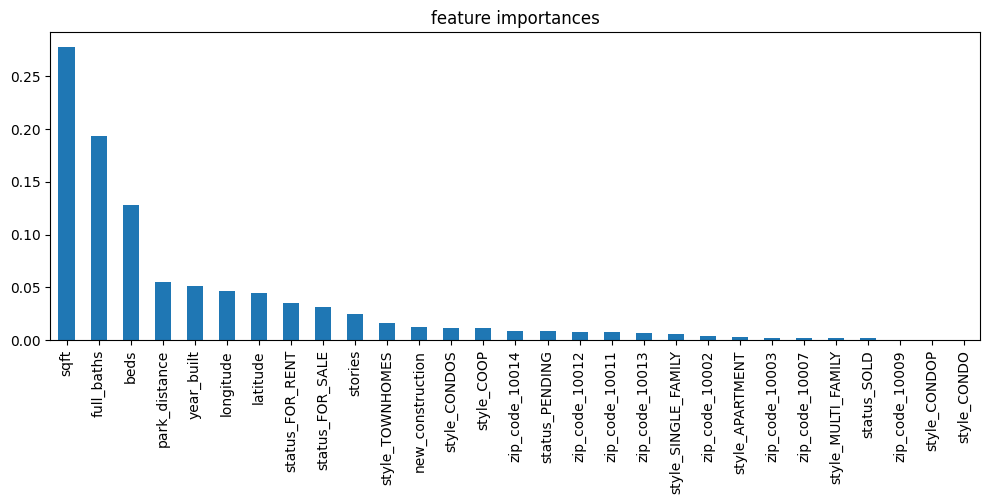

In [71]:
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,4))
plt.title('feature importances')
plt.show() 

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


best parameters: 
{'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 91}
best cv score: 0.73
r2 score: 0.72
mape score: 11.65


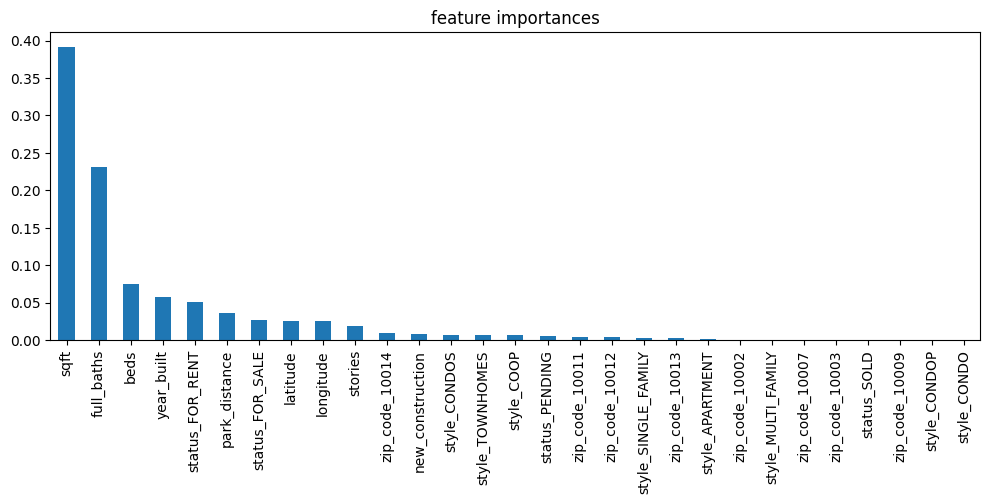

In [72]:
# fine tuning via random search 

param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None, 0.5, 0.8] 
}

rand_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring='r2',
    n_jobs = -1,
    random_state=42
)
rand_search.fit(X_train, y_train) 

print(f'best parameters: \n{rand_search.best_params_}')
print(f'best cv score: {rand_search.best_score_:.2f}')

y_preds = rand_search.predict(X_test)
print(f'r2 score: {r2_score(y_test, y_preds):.2f}')
print(f'mape score: {mean_absolute_percentage_error(y_test, y_preds):.2f}')

best_rf = rand_search.best_estimator_

feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,4))
plt.title('feature importances')
plt.show()

In [81]:
# save the model so it persists
joblib.dump(best_rf, 'final_model.joblib')
joblib.dump(X_train.columns.tolist(), 'model_columns.joblib')

['model_columns.joblib']

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


After experimenting with various data transformations, models, and rounds of fine-tuning, it can be fully concluded that:
- for data transformations, imputation via median and knn both severely deteriorated model performance
  - r2 scores were in negatives, and mape scores were >1
- best approach was to simply drop these rows
  - this was experimented and proven twice:
    - when X_test had only ~250 rows, r2 scores finally reached 0.60s
    - after expanding the geographical scope, when X_test had ~1000 rows, r2 scores reached mid 0.70s
 
As for the columns used:
- style (10 different String styles; however, these proved to have little to not impact in final model training)
- status (had a pretty significant effect in model training——this makes sense, since sold properties vs. rental properties have widely differing price ranges)
- beds (many null values had to be dropped; however, in model training, this column proved to be effective in predicting property price)
- full_baths (same notes as beds, except that there were much less null values to drop)
- year_built (old vintage charm vs. modern renovated interiors. made sense to keep when training model, and this guess was later proven)
- latitude/longitude (didn't play that big of a role; mostly used to calculate park_distance)
- park_distance (contributed greatly to modern training)
- stories (in my opinion didn't play as large of a role as i would've expected)
- zip_codes (played much less of a role than i would've expected; since this is essentially what separates these neighborhoods, i was surprised to discover their minimal role in model training)

## final conclusion:
New York City housing prices are known for their volatility; the smallest of factors, such as distance to certain prestigious public schools or seclusivity from crowded urban centers. Hence, I tried to focus on as small an area as possible to retain homogenity across my model. However, I found that I also had to balance this with having enough data, since dropping rows with null values would typically result in a loss of ~25% of existing data.

Although slightly lower than I'd like, a model of ~0.70 r2 score and ~10 mape score can moderately predict NYC housing prices in the Downtown Manhattan region accurately. 

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [82]:
print(combined2.columns)
print(combined2['zip_code'].value_counts())

Index(['status', 'style', 'zip_code', 'beds', 'full_baths', 'sqft',
       'year_built', 'list_price', 'new_construction', 'latitude', 'longitude',
       'stories', 'park_distance'],
      dtype='object')
zip_code
10011    339
10013    224
10002    217
10003    189
10012    111
10014    105
10007     93
10009     49
Name: count, dtype: int64


In [7]:
"""
========PARAMETERS GUIDE========
status (str):
    - the current status of the property 
    - must be one of the following: [FOR_SALE, PENDING, FOR_RENT, SOLD] 

style (str): 
    - the property style
    - must be one of the following: [CONDOS, COOP, APARTMENT, SINGLE_FAMILY, TOWNHOMES, MULTI_FAMILY, 
    TOWNHOMES, MULTI_FAMILY, CONDOP, CONDO]

zip_code (int):
    - 5-digit integer representing the zip code the property is located in
    - must be one of the following: [10011, 10013, 10002, 10003, 10012, 10014, 10007, 10009]

beds (int):
    - an integer representing the number of bedrooms in the property

full_baths (int):
    - an integer representing the number of full bathrooms in the property

sqft (int):
    - an integer representing the number of square feet in the property

year_built (int):
    - an 4-digit integer representing the year the property was built in

new_construction (bool):
    - a boolean indicating whether a property was constructed/renovated recently (True) or not (False) 

latitude (float):
    - a float indicating the latitude coordinates where the property is located. 

longitude (float):
    - a float indicating the longitude coordinates where the property is located. 

stories (int):
    - an integer indicating the number of stories the property has. 

========RETURNS========

predicted_price (float):
    - the predicted price of the property by the model

"""

def calc_distance(latitude: float, longitude: float) -> float: 
    # destination is washington square park
    DESTINATION_LAT = 40.7308
    DESTINATION_LONG = -73.9976

    R = 6371 # earth's radius 

    lat1 = np.radians(latitude) 
    long1 = np.radians(longitude) 

    lat2 = np.radians(DESTINATION_LAT)
    long2 = np.radians(DESTINATION_LONG)

    long_dist = long2 - long1
    lat_dist = lat2 - lat1 

    a = np.sin(lat_dist / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_dist / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c # returns distance in km 

def inference(status: str, style: str, zip_code: int, beds: int, full_baths: int,
              sqft: int, year_built: int, new_construction: bool, latitude: float, 
              longitude: float, stories: int,) -> float:

    model = joblib.load('final_model.joblib')
    expected_cols = joblib.load('model_columns.joblib')
    
    park_distance = calc_distance(latitude, longitude) 
    
    params = pd.DataFrame({
        'status': [status],
        'style': [style],
        'zip_code': [zip_code],
        'beds': [beds],
        'full_baths': [full_baths],
        'sqft': [sqft],
        'year_built': [year_built],
        'new_construction': [new_construction],
        'latitude': [latitude],
        'longitude': [longitude],
        'stories': [stories],
        'park_distance': [park_distance]
    })
    
    encoded_df = pd.get_dummies(params, columns=['status', 'style', 'zip_code'], drop_first=False) 
    for col in expected_cols:
        if col not in encoded_df.columns:
            encoded_df[col] = False

    encoded_df = encoded_df.reindex(columns=expected_cols, fill_value=False) 

    prediction = model.predict(encoded_df)
    return prediction[0]

# run here:
# 
# price = inference(status=,
#                   style=,
#                   zip_code=,
#                   beds=,
#                   full_baths=,
#                   sqft=,
#                   year_built=,
#                   new_construction=,
#                   latitude=,
#                   longitude=,
#                   stories=,
#                  )
# print(f'price of this property is predicted to be: ${price:.2f}')

price = inference(status='FOR_SALE',
                  style='CONDO',
                  zip_code=10013,
                  beds=3,
                  full_baths=3,
                  sqft=2635,
                  year_built=1898,
                  new_construction=True,
                  latitude=40.716434,
                  longitude=74.003342,
                  stories=13,
                 )
print(f'price of this property is predicted to be: ${price:.2f}')


price of this property is predicted to be: $6349687.94
